In [1]:
import re
import os
import sys
import pprint

from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

assin_idx = [[55, 60], [65, 70], [152, 157], [173, 177]]
tweetsent_idx = [[6, 12], [22, 27], [33, 38], [45, 50]]
LEGEND_TITLE = 'Training set'

assin_metrics = [
    'Accuracy',
    'Macro F1',
    'Pearson',
    'Mean Squared Error',
]

tweetsent_metrics = [
    'Accuracy',
    'F1. neg',
    'F1. neu',
    'F1. pos',
]

models_dict = {
    'bert_base': 'bert_base',
    'bert_large': 'bert_large',
    'mt-dnn_base': 'mt-dnn_base',
    'mt-dnn_large': 'mt-dnn_large',
    'bert-multilingual_base': 'bert-multilingual_base',
    'bert-pt_base': 'bert-pt_base',
    'bert-pt_large': 'bert-pt_large',
}


approaches_dict = {
    'st-dnn': 'st-dnn',
    'mt-dnn_assin': 'mt-dnn_assin',
    'mt-dnn_assin+tweetsent': 'mt-dnn_assin+tweetsent',
    'mt-dnn_assin-ptbr+assin2': 'mt-dnn_assin-ptbr+assin2',
    'mt-dnn_assin2': 'mt-dnn_assin2',
    'st-dnn/assin-1+2': 'st-dnn/assin-1+2',
    'st-dnn/assin-ptbr+2': 'st-dnn/assin-ptbr+2',
    'st-dnn/assin1-rte': 'st-dnn/assin1-rte',
    'st-dnn/best-pt': 'st-dnn/best-pt',
    'st-dnn/random-pt': 'st-dnn/random-pt',
    'st-dnn/worst-pt': 'st-dnn/worst-pt',
}


def is_assin(task_name: str):
    return 'assin' in task_name


def get_idx(task: str, assin: bool):
    idx = assin_idx if assin else tweetsent_idx

    return idx


def get_float(string: str, float_pos: List[int]):
    start, end = float_pos[0], float_pos[1]
    float_num = string[start:end]
    float_num = float(float_num)

    return float_num


def get_metric_name(metric_idx: int, assin: bool):
    metrics_names = assin_metrics if assin else tweetsent_metrics
    metric_name = metrics_names[metric_idx]

    return metric_name


def get_metric(task: str, task_name: str, metric_idx: int) -> tuple:
    task_idx = get_idx(task, is_assin(task_name))[metric_idx]
    metric = get_float(task, task_idx)

    return metric


def get_evals(report: str, task_name: str, model_set: set):
    tasks = re.split('corpus.*|Saving generated XMLs...', report)
    tasks = [task for task in tasks
             if f'{task_name}_eval.txt' in task and any(model in task for model in model_set)]

    evals = {model: dict() for model in model_set}
    pattern = re.compile(
        r'report/(.*?)/(.*?)/.*/dropout/\d+\.\d+(/*.*)/.*?txt')
    for task in tasks:
        mode, model, extra = re.search(pattern, task).groups()
        evals[model].update({mode + extra: task})

    return evals


def get_report(filepath: str):
    with open(filepath) as f:
        report = f.read()
        report = re.sub('\n\n\n\n*', '\n\n', report)

    return report


def get_scores_dict(filepath: str, model_set: set, task_name: str, metric_idx: int, models_lang: str, cabezudo: bool):
    report = get_report(filepath)
    evals = get_evals(report, task_name, model_set)
    scores = dict()

    if task_name.startswith('assin-') and models_lang == 'pt':
        cabezudo_approaches = {
            'st-dnn/assin1-rte',
            'st-dnn/best-pt',
            'st-dnn/random-pt',
            'st-dnn/worst-pt',
        }

        approaches = set(list(evals.values())[0].keys())
        remove_approaches = cabezudo_approaches if metric_idx >= 2 or cabezudo == False else approaches - cabezudo_approaches

        for model in evals:
            for approach in remove_approaches:
                evals[model].pop(approach)

    for model in evals:
        scores[model] = {key: get_metric(value, task_name, metric_idx)
                         for key, value in evals[model].items()}

    return scores


def get_models_scores_dict(files: List[str], model_set: set, task_name: str, metric_idx: int, models_lang: str, cabezudo: bool):
    scores_dict_lst = [get_scores_dict(filepath, model_set, task_name, metric_idx, models_lang, cabezudo)
                       for filepath in files]

    models_scores_dict = dict()
    for model in model_set:
        models_scores_dict[model] = [scores[model]
                                     for scores in scores_dict_lst]

    return models_scores_dict


def adjust_legend(graphs, labels, handle_text):
    class TextHandler(HandlerBase):
        def create_artists(self, legend, tup, xdescent, ydescent,
                           width, height, fontsize, trans):
            tx = Text(
                width/2.,
                height/2,
                tup[0],
                fontsize=fontsize,
                ha="center",
                va="center",
                # color=tup[1],
                # fontweight="bold",
                alpha=1,
            )
            return [tx]

    for graph in graphs:
        graph.set_xticklabels(handle_text)

    handles = [(l, a.get_facecolor())
               for l, a in zip(handle_text, graphs[0].artists)]

    graph.legend(handles,
                 labels,
                 bbox_to_anchor=(1, 1),
                 handler_map={tuple: TextHandler()},
                 title=LEGEND_TITLE
                 )


def box_plot(dfs):
    sns.set(
        font='Open Sans',
        context="paper",
        style="whitegrid",
    )

    fig, graphs = plt.subplots(1, len(dfs))
    size = fig.get_size_inches()
    fig.set_size_inches(size[0]*2, size[1])

    labels = [approaches_dict[label] for label in dfs[0].columns.values]
    handle_text = range(1, 1 + len(labels))

    color_palette = sns.cubehelix_palette(len(labels), dark=0.2)

    for idx, df in enumerate(dfs):
        sns.boxplot(ax=graphs[idx],
                    data=df,
                    palette=color_palette,
                    showmeans=False,
                    boxprops=dict(alpha=0.5),
                    meanprops=dict(
            alpha=1,
            markerfacecolor='black',
            markeredgecolor='black',
            markersize=10,
        ),
        )
    adjust_legend(graphs, labels, handle_text)

    return fig, graphs


def draw_blox_plot(model_scores_dict: Dict[str, list], task_name: str, metric_idx: int, models_lang: str, cabezudo: bool):
    xlabel = "Aproaches"
    ylabel = get_metric_name(metric_idx, is_assin(task_name))

    dfs = list()
    for model, scores in model_scores_dict.items():
        df = pd.DataFrame(scores)
        df.name = model
        dfs.append(df)

    fig, graphs = box_plot(dfs)
    for idx, graph in enumerate(graphs):
        graph.set_title(models_dict[dfs[idx].name])
        graph.set_ylabel(ylabel)

    fig.tight_layout()

#     filename = f'{task_name}_{models_lang}_cabezudo' if cabezudo else f'{task_name}_{models_lang}_{metric_idx}'
#     plt.savefig(f'boxplot/{filename}.png')
    return fig, graphs


def get_data(task_name: str, models_lang: str, metric_idx: int, cabezudo: bool):
    path = 'report/seed'
    models = {
        'en': {
            'mt-dnn_base',
            'bert_base',
            'bert_large',
            'mt-dnn_large',
        },
        'pt': {
            'bert-multilingual_base',
            'bert-pt_base',
            'bert-pt_large',
        }
    }

    metric_idx = int(metric_idx)
    model_set = models[models_lang]

    pattern = re.compile(r'\d\d\d\d_.*_.*.txt')
    files = [f'{path}/{filename}' for filename in os.listdir(
        path) if re.search(pattern, filename)]
    models_scores_dict = get_models_scores_dict(
        files, model_set, task_name, metric_idx, models_lang, cabezudo)
    return models_scores_dict


# draw_blox_plot(models_scores_dict, task_name, metric_idx, models_lang, cabezudo)

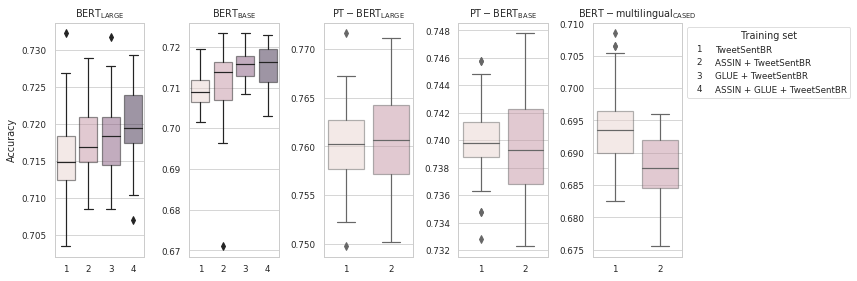

In [9]:
def rename_columns(list_of_dicts, rename_dict):
    return pd.DataFrame(list_of_dicts).rename(columns=rename_dict).to_dict('records')

tweetsent_en_data = get_data('tweetsent', 'en', 0, False)
tweetsent_pt_data = get_data('tweetsent', 'pt', 0, False)

## English

rename_dict = {
    "st-dnn": "TweetSentBR",
    "mt-dnn_assin+tweetsent": "ASSIN + TweetSentBR"
}
tweetsent_en_data['bert_large'] = rename_columns(tweetsent_en_data['bert_large'], rename_dict)

rename_dict = {
    "st-dnn": "GLUE + TweetSentBR",
    "mt-dnn_assin+tweetsent": "ASSIN + GLUE + TweetSentBR"
}
tweetsent_en_data['mt-dnn_large'] = rename_columns(tweetsent_en_data['mt-dnn_large'], rename_dict)

rename_dict = {
    "st-dnn": "TweetSentBR",
    "mt-dnn_assin+tweetsent": "ASSIN + TweetSentBR"
}
tweetsent_en_data['bert_base'] = rename_columns(tweetsent_en_data['bert_base'], rename_dict)

rename_dict = {
    "st-dnn": "TweetSentBR",
    "mt-dnn_assin+tweetsent": "ASSIN + TweetSentBR"
}

rename_dict = {
    "st-dnn": "GLUE + TweetSentBR",
    "mt-dnn_assin+tweetsent": "ASSIN + GLUE + TweetSentBR"
}
tweetsent_en_data['mt-dnn_base'] = rename_columns(tweetsent_en_data['mt-dnn_base'], rename_dict)

tweetsent_en_data['$\mathregular{BERT_{LARGE}}$'] = tweetsent_en_data['bert_large'] + tweetsent_en_data['mt-dnn_large']
tweetsent_en_data['$\mathregular{BERT_{BASE}}$'] = tweetsent_en_data['bert_base'] + tweetsent_en_data['mt-dnn_base']

remove_keys = [ key for key in tweetsent_en_data.keys() if '$' not in key ]
for key in remove_keys:
    tweetsent_en_data.pop(key)

approaches_dict = {
    "TweetSentBR": "TweetSentBR",
    "ASSIN + TweetSentBR": "ASSIN + TweetSentBR", 
    "GLUE + TweetSentBR": "GLUE + TweetSentBR",
    "ASSIN + GLUE + TweetSentBR": "ASSIN + GLUE + TweetSentBR"
}

models_dict = {
    '$\mathregular{BERT_{LARGE}}$': '$\mathregular{BERT_{LARGE}}$',
    '$\mathregular{BERT_{BASE}}$': '$\mathregular{BERT_{BASE}}$'
}

## Portuguese

rename_dict = {
    "st-dnn": "TweetSentBR",
    "mt-dnn_assin+tweetsent": "ASSIN + TweetSentBR"
}
for key in tweetsent_pt_data.keys():
    tweetsent_pt_data[key] = rename_columns(tweetsent_pt_data[key], rename_dict)

tweetsent_pt_data['$\mathregular{PT-BERT_{LARGE}}$'] = tweetsent_pt_data.pop('bert-pt_large')
tweetsent_pt_data['$\mathregular{PT-BERT_{BASE}}$'] = tweetsent_pt_data.pop('bert-pt_base')
tweetsent_pt_data['$\mathregular{BERT-multilingual_{CASED}}$'] = tweetsent_pt_data.pop('bert-multilingual_base')


## Join English + Portuguese

pt_models_dict = { k:k for k in tweetsent_pt_data.keys() }
models_dict.update(pt_models_dict)

tweetsent_en_data.update(tweetsent_pt_data)

fig, graphs = draw_blox_plot(tweetsent_en_data, 'tweetsent', 0, 'en', False)

for g in graphs:
    g.axes.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

for idx, item in enumerate(fig.axes):
    if idx:
#         fig.axes[idx].yaxis.set_ticklabels([])
        fig.axes[idx].set_ylabel('')

plt.subplots_adjust(wspace=0.5, hspace=0)

fig